# EDA

## Config

In [1]:
from recognizer.utils.constants import ROOT_DIR, DATASET_DIR
from recognizer.utils.utils import get_metadata_from_filename

In [3]:
import os

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR):
    if "left" in file:
        continue

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR / file).resolve()))

In [4]:
import pandas as pd 

metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata.head()

,target,subject,repetition,file
0,064,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
2,033,009,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...


## Distribution of classes

<AxesSubplot: xlabel='target', ylabel='count'>

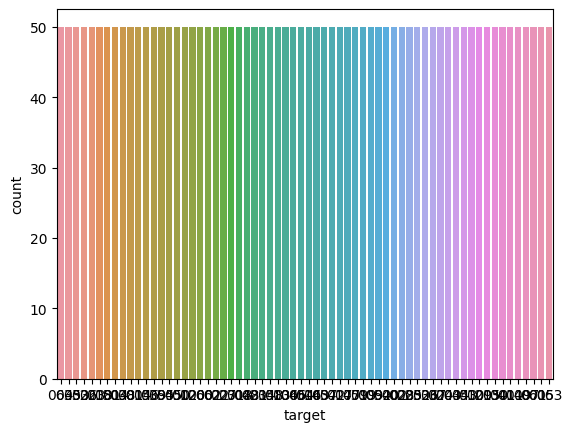

In [15]:
import seaborn as sns

sns.countplot(data=metadata, x="target")

## Frames per video

We find that every video has equal FPS (59.94) but different duration.

In [55]:
import cv2

from typing import Tuple

def get_video_stats(path_fo_video_file: str) -> Tuple[float, float, float]:
    video = cv2.VideoCapture(path_fo_video_file)

    frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS)

    return frames, fps, frames/fps

In [56]:
metadata.loc[:, "tuples"] = metadata["file"].apply(get_video_stats)

metadata[["frames", "fps", "duration"]] = pd.DataFrame(metadata['tuples'].tolist(), index=metadata.index)

metadata.drop(labels=["tuples"], axis=1, inplace=True)

metadata.head()

,target,subject,repetition,file,frames,fps,duration
0,064,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,70.0,59.94,1.167835
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,114.0,59.94,1.901902
2,033,009,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,79.0,59.94,1.317985
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,115.0,59.94,1.918585
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,73.0,59.94,1.217885


In [57]:
pd.DataFrame(
    [
        metadata.frames.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metadata.fps.describe(percentiles=[.1, .25, .5, .75, .9, .99]),
        metadata.duration.describe(percentiles=[.1, .25, .5, .75, .9, .99])
    ]
)

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
frames,3200.0,82.759687,2.758078e+01,14.000000,50.000000,65.000000,78.000000,100.000000,118.000000,159.000000,201.000000
fps,3200.0,59.940000,2.131961e-14,59.940000,59.940000,59.940000,59.940000,59.940000,59.940000,59.940000,59.940000
duration,3200.0,1.380709,4.601399e-01,0.233567,0.834168,1.084418,1.301301,1.668335,1.968635,2.652653,3.353353


In [58]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='frames', ylabel='Count'>

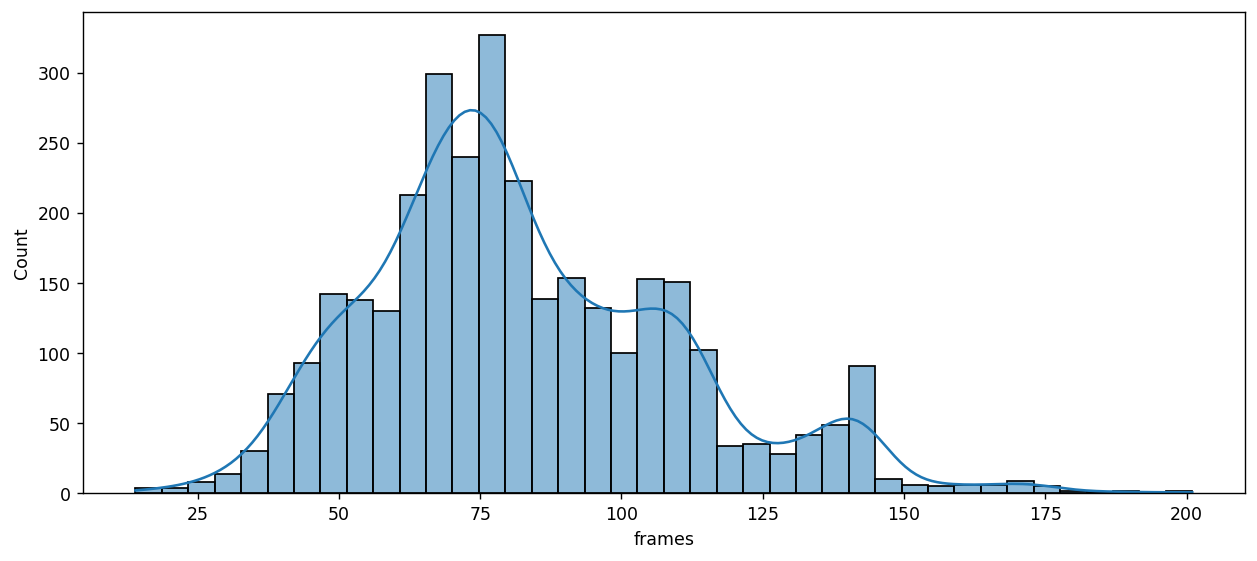

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), facecolor="white", dpi=125)

sns.histplot(data=metadata, x="frames", ax=ax, kde=True)

## Average frames for each class

Some (words) classes have more frames on average than others

In [77]:
frames_by_target = (
    metadata.groupby(by=["target"])["frames"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
)

frames_by_target.head()

,target,min,max,mean,std
0,001,31.0,129.0,68.02,19.995397
1,002,54.0,123.0,77.82,16.518005
2,003,49.0,102.0,71.94,12.627165
3,004,39.0,101.0,54.92,13.579456
4,005,46.0,130.0,86.60,19.992856


In [129]:
from recognizer.utils.constants import TARGET_TO_WORD

frames_by_target["label"] = frames_by_target.target.map(TARGET_TO_WORD)

ImportError: cannot import name 'TARGET_TO_WORD' from 'recognizer.utils.constants' (/Users/facundopalavecino/Documents/DEV/ecd-trabajo-final/recognizer/utils/constants.py)

<AxesSubplot: xlabel='mean', ylabel='label'>

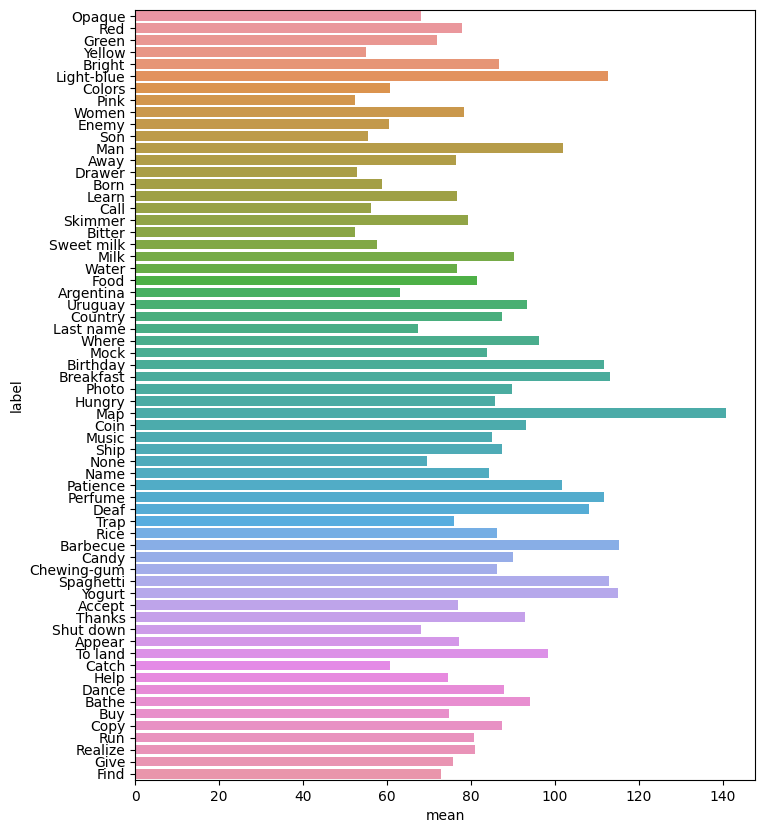

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))

sns.barplot(data=frames_by_target, y="label", x="mean", ax=ax)

## Train/Test split

The goal is to split the dataset in 2 maintaining the proportion of classes in each set

In [90]:
metadata.head()

,target,subject,repetition,file,frames,fps,duration
0,064,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,70.0,59.94,1.167835
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,114.0,59.94,1.901902
2,033,009,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,79.0,59.94,1.317985
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,115.0,59.94,1.918585
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,73.0,59.94,1.217885


In [122]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

testing_set

,target,subject,repetition,file,frames,fps,duration
1059,001,001,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,67.0,59.94,1.117784
1291,001,002,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,93.0,59.94,1.551552
1384,001,003,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,73.0,59.94,1.217885
1556,001,004,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,59.0,59.94,0.984318
1837,001,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,65.0,59.94,1.084418
...,...,...,...,...,...,...,...
148,064,006,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,75.0,59.94,1.251251
508,064,007,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,54.0,59.94,0.900901
3036,064,008,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,67.0,59.94,1.117784
1431,064,009,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,71.0,59.94,1.184518


In [123]:
training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

training_set

,target,subject,repetition,file,frames,fps,duration
1,035,010,003,/Users/facundopalavecino/Documents/DEV/ecd-tra...,114.0,59.94,1.901902
3,026,002,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,115.0,59.94,1.918585
4,023,005,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,73.0,59.94,1.217885
5,018,008,001,/Users/facundopalavecino/Documents/DEV/ecd-tra...,79.0,59.94,1.317985
6,051,007,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,89.0,59.94,1.484818
...,...,...,...,...,...,...,...
3193,047,003,005,/Users/facundopalavecino/Documents/DEV/ecd-tra...,103.0,59.94,1.718385
3194,035,001,005,/Users/facundopalavecino/Documents/DEV/ecd-tra...,108.0,59.94,1.801802
3195,060,002,002,/Users/facundopalavecino/Documents/DEV/ecd-tra...,74.0,59.94,1.234568
3196,059,007,004,/Users/facundopalavecino/Documents/DEV/ecd-tra...,92.0,59.94,1.534868


<AxesSubplot: xlabel='count', ylabel='target'>

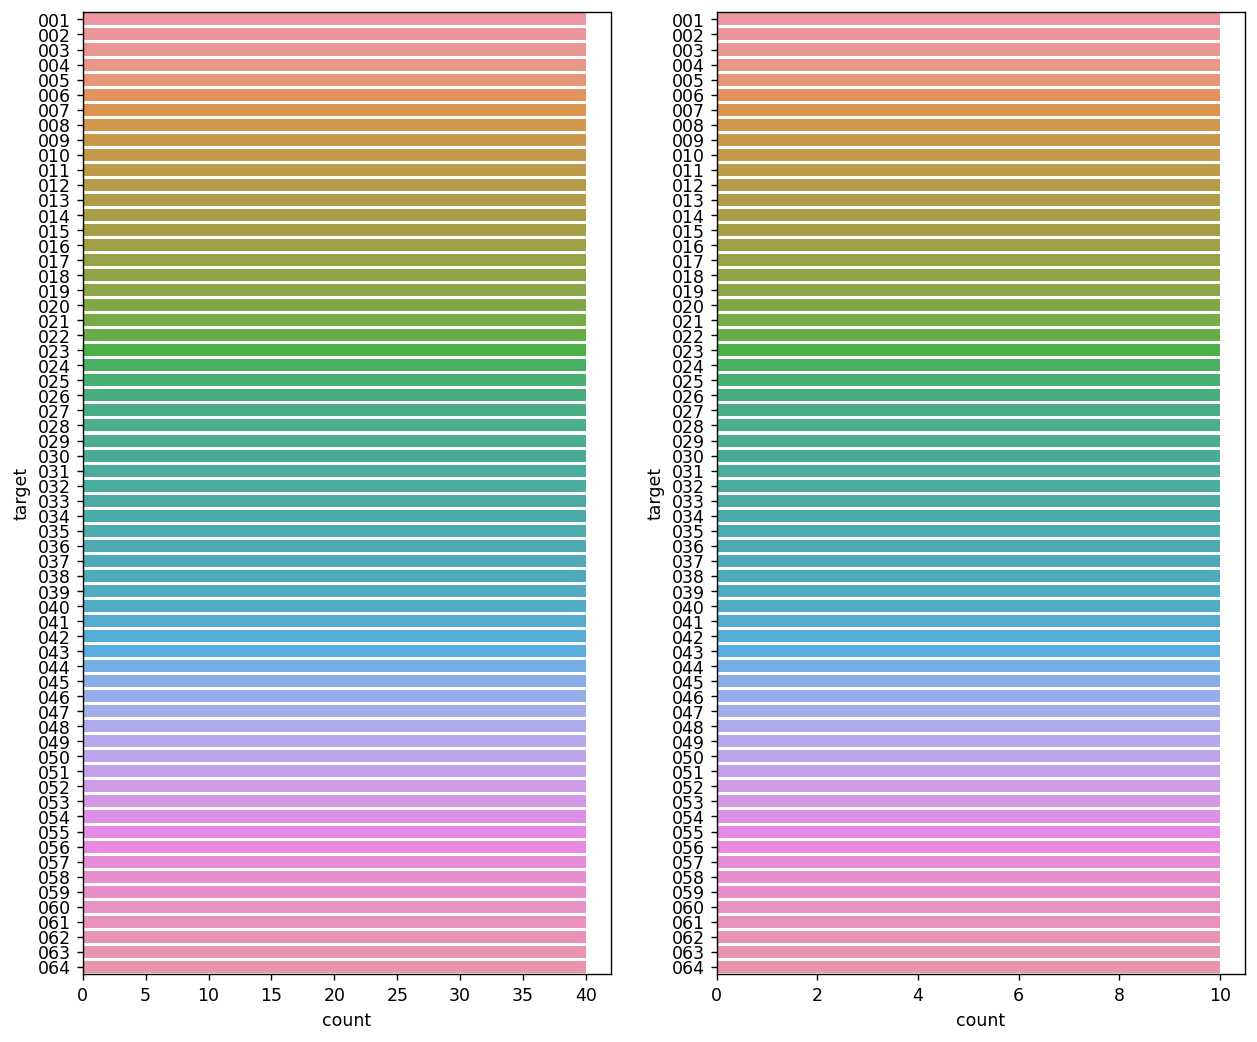

In [124]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), facecolor="white", dpi=125)

sns.countplot(data=training_set.sort_values(["target"]), y="target", ax=axs[0])

sns.countplot(data=testing_set.sort_values(["target"]), y="target", ax=axs[1])

## Transforming label to Pytorch encoding

In [126]:
# Create a mapping from string class labels to integer indices
class_to_idx = {str(i).zfill(3): i-1 for i in range(1, 65)}

metadata['target'].map(class_to_idx)

0       63
1       34
2       32
3       25
4       22
        ..
3195    59
3196    58
3197    26
3198    29
3199     8
Name: target, Length: 3200, dtype: int64